# Deep learning forecasting with DARTS

Using the N-BEATS model: Neural Basis Expansion Analysis Time Series Forecasting 

* **Training a DL model on a single multivariate series**

Paper: https://openreview.net/forum?id=r1ecqn4YwB

netcdf loading into TensorFlow: https://www.noahbrenowitz.com/post/loading_netcdfs/

Deep learning course here: https://course.fast.ai/

Deep Spatiotemporal prediction https://github.com/amirkhango/DeepST

In [1]:
# General Imports
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline     

# Forecasting imports
from darts.models import NBEATSModel
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.timeseries_generation import datetime_attribute_timeseries
# from darts.utils.statistics import extract_trend_and_seasonality, remove_trend
from darts.utils.utils import SeasonalityMode
from darts import TimeSeries
from darts.metrics import mae, mape
from darts.dataprocessing.transformers import Scaler

#causal variable selection
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr
from tigramite.models import Prediction
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/../versions.py'
  warnings.warn(str(e))
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: [Errno 2] No such file or directory: '/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/../../versions.py'
  warnings.warn(str(e))
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'gpytorch'
  warnings.warn(str(e))
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/models.py:29: UserWarning: [Errno 2] No such file or directory: '/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/../versio

## Analysis Parameters


<!-- CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Daily.nc

CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Monthly.nc -->

<!-- Tumbarumba/2022_v1/L6/default/Tumbarumba_L6_20020107_20191231_Daily.nc

'AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Daily.nc'

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Monthly.nc

'Tumbarumba/2022_v1/L6/default/Tumbarumba_L6_20020107_20191231_Monthly.nc'

/Gingin/2022_v1/L6/default/Gingin_L6_20111013_20201231_Monthly.nc

Gingin/2022_v1/L6/default/Gingin_L6_20111013_20201231_Daily.nc

CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Monthly.nc

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Monthly.nc

Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Monthly.nc

Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Daily.nc

DryRiver/2022_v1/L6/default/DryRiver_L6_20091025_20220218_Monthly.nc

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Daily.nc

GreatWesternWoodlands/2022_v1/L6/default/GreatWesternWoodlands_L6_20130101_20220101_Daily.nc

GreatWesternWoodlands/2022_v1/L6/default/GreatWesternWoodlands_L6_20130101_20220101_Monthly.nc 

In [2]:
site = 'DryRiver/2022_v1/L6/default/DryRiver_L6_20091025_20220218_Daily.nc'
        
# site = '/g/data/os22/chad_tmp/NEE_modelling/data/ec_netcdfs/Gingi_EC_site.nc'
var = ['GPP_SOLO', 'Ta', 'VPD','Precip', 'ET', 'Fsd']
var_names = ['GPP','Ta', 'VPD', 'precip', 'ET', 'solar']
test_split=0.80
n=12

## Load data

In [3]:
def VPD(rh, ta):
    sat_vp = (6.11 * np.exp((2500000/461) * (1/273 - 1/(273 + ta))))
    vpd = (((100 - rh)/100) * sat_vp)
    return vpd

ds = xr.open_dataset('https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/'+site)
ds['GPP_SOLO'] = xr.where(ds.GPP_SOLO < 0, 0, ds.GPP_SOLO)  #Set negative GPP, ER, and ET measurements as zero
ds['ER_SOLO'] = xr.where(ds.ER_SOLO < 0, 0, ds.ER_SOLO)  #Set negative GPP, ER, and ET measurements as zero
ds['ET'] = xr.where(ds.ET < 0, 0, ds.ET)  #Set negative GPP, ER, and ET measurements as zero
ds['VPD'] = VPD(ds.RH, ds.Ta)
ds = ds[var]

# anomalization
# ds_clim_mean = ds.groupby('time.month').mean()
# ds = (ds.groupby('time.month') - ds_clim_mean)

ds = ds.resample(time='1W').mean()

df = ds.to_dataframe().reset_index(
        level=[1, 2]).drop(['latitude', 'longitude'], axis=1)

df = df[var].dropna()

In [4]:
# site = '/g/data/os22/chad_tmp/NEE_modelling/results/training_data/Great_training_data.csv'
# var = ['GPP_SOLO_EC', 'Ta_EC', 'VPD_EC', 'precip_RS', 'LAI_RS', 'ET_EC', 'solar_RS']
# var_names = ['GPP','Ta', 'VPD', 'precip', 'LAI', 'ET', 'solar']

# df_in = pd.read_csv(site, index_col='time', parse_dates=True)
# df_in = df_in[var]

# df_in = df_in.reset_index()
# df_in['time'] = df_in['time'].astype("datetime64[M]")
# df_in = df_in.set_index('time')

## Casual predictor selection

In [5]:
import sklearn
from sklearn.ensemble import RandomForestRegressor

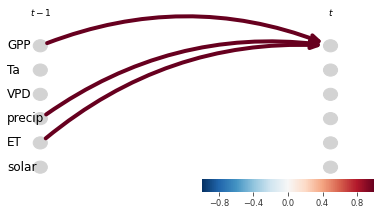

In [6]:
target=0
tau_max=1
steps_ahead=1
data = df.values
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
dataframe = pp.DataFrame(data, 
                         datatime = {0:np.arange(len(data))}, 
                         var_names=var_names)

pred = Prediction(dataframe=dataframe,
        cond_ind_test=ParCorr(), 
        prediction_model=RandomForestRegressor(),
        # data_transform=sklearn.preprocessing.StandardScaler(),
        train_indices= range(int(0.95*T)),
        test_indices= range(int(0.95*T), T),
        verbosity=0
    )

# Make solar have no parents
selected_links = {}

for j in range(N):
    if j in list(range(N-1)):
        selected_links[j] = [(var, -lag) for var in range(N)
                         for lag in range(0, tau_max + 1)]
    else:
        selected_links[j] = []

predictors = pred.get_predictors(
                  selected_targets=[target],
                  steps_ahead=steps_ahead,
                  tau_max=tau_max,
                  pc_alpha=0.05,
                  selected_links=selected_links
                  )

graph = np.zeros((N, N, tau_max+1), dtype='bool')

for j in [target]:
    for p in predictors[j]:
        graph[p[0], j, abs(p[1])] = 1

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
#     node_aspect=2.,
    val_matrix=np.ones(graph.shape),
    graph=graph,
    var_names=var_names,
    link_colorbar_label='',
    );

### Remove variables not casually related

In [7]:
gpp_predictors = predictors.get(target)
results = []
for i in gpp_predictors:
    col = df.columns[i[0]]
    results.append(col)

df = df[results]

### Training with climate as multivariate

In [8]:
series_gpp = TimeSeries.from_dataframe(df)

### Training with climate as covariables

In [9]:
# #target variable
# series_gpp = TimeSeries.from_dataframe(df_in, value_cols=[var[0]])

# # series_gpp = remove_trend(series_gpp)

# #covariates
# covariates = df_in[df_in.columns[1]] 
# covariates = TimeSeries.from_series(covariates)

# if len(df_in.columns) > 2:
#     for i in range(0, len(df_in.columns[2:])):
#         series =  df_in[df_in.columns[2+i]]
#         series = TimeSeries.from_series(series)
#         covariates=covariates.stack(series)
        
# #add seasonality and trend as covariates
# trends = extract_trend_and_seasonality(series_gpp, model =SeasonalityMode.ADDITIVE, method='STL')
# covariates = covariates.stack(trends[0])
# covariates = covariates.stack(trends[1])

## Fit a model on training dataset

Scaling data before fitting

<!-- # RNN Model
# model = BlockRNNModel(
#     model="LSTM",
#     input_chunk_length=int(len(df)/3),
#     output_chunk_length=3,
#     pl_trainer_kwargs={'accelerator':'cuda', 'devices':1} #use GPUs
# )

# model = TCNModel(
#     input_chunk_length=int(len(df)/3),
#     output_chunk_length=3
# )

# model = LightGBMModel(lags=3, lags_past_covariates=3, output_chunk_length=3, likelihood='quantile')
# model = LinearRegressionModel(lags=3, lags_past_covariates=3, output_chunk_length=3, likelihood='quantile') -->

In [10]:
scaler = Scaler()
series_gpp_scaled = scaler.fit_transform(series_gpp)

# scaler_cov = Scaler()
# covariates = scaler_cov.fit_transform(covariates)

In [11]:
%%time

idx = int(len(series_gpp_scaled)*test_split)
train, val = series_gpp_scaled.split_after(pd.Timestamp(series_gpp_scaled[idx].data_array().time.values[0]))
# cov_train, cov_val = covariates.split_after(pd.Timestamp(series_gpp[idx].data_array().time.values[0]))

# covariables as enconders
encoders = {
    # "cyclic": {"future": ["month"]},
    "datetime_attribute": {"past":["week", "month", "year"]},
    # "position": {"past": ["absolute"], "future": ["relative"]},
    "transformer": Scaler(),
}

model = NBEATSModel(input_chunk_length=104,
                    output_chunk_length=n,
                    generic_architecture=False,
                    likelihood=QuantileRegression(),
                    random_state=0,
                    n_epochs=80,
                    add_encoders=encoders,
                    pl_trainer_kwargs={'accelerator':'cpu', #use cpus
                                      # "enable_progress_bar": False
                                      } 
                    # pl_trainer_kwargs={'accelerator':'cuda', 'devices':1,} #use GPUs
                   )

model.fit(train)

2022-08-22 14:00:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 400 samples.
2022-08-22 14:00:38 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-08-22 14:00:39 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-08-22 14:00:39 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-08-22 14:00:39 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-08-22 14:00:39 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-08-22 14:00:39 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.6 M 
--

Training: 0it [00:00, ?it/s]

2022-08-22 14:02:11 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=80` reached.


CPU times: user 16min 40s, sys: 8.02 s, total: 16min 48s
Wall time: 1min 33s


## Predict on validation dataset

Predicting: 13it [00:00, ?it/s]

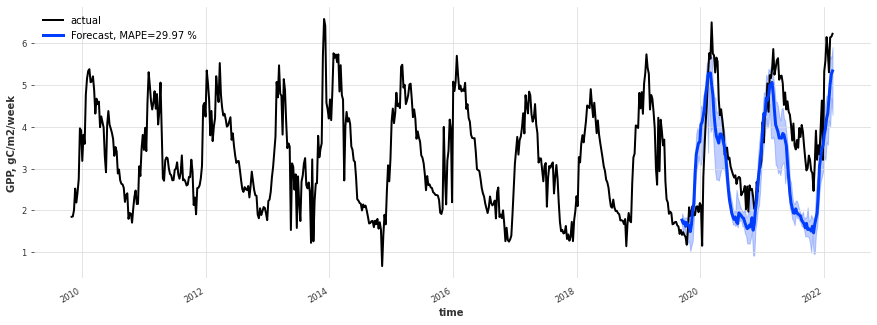

In [12]:
pred = model.predict(n=len(val), series=train, num_samples=100) #past_covariates=covariates

pred_r = scaler.inverse_transform(pred)
val_r = scaler.inverse_transform(val)
err = mape(val_r['GPP_SOLO'], pred_r['GPP_SOLO'])

fig,ax = plt.subplots(figsize=(15,5))
series_gpp['GPP_SOLO'].plot(ax=ax, label='actual')

pred_r['GPP_SOLO'].plot(ax=ax, lw=3,
                                    label='{}, MAPE={:.2f} %'.format('Forecast', err))
plt.ylabel(var_names[0]+', gC/m2/week')
# plt.axhline(0, color='grey')
plt.legend()

### Iterative backtest

In [13]:
backtests = model.historical_forecasts(series_gpp_scaled,
                                       # past_covariates=covariates,
                                       num_samples=100,
                                       start=.5,
                                       retrain=False,
                                       forecast_horizon=n,
                                       stride=1,
                                       verbose=True
                                      )

# # lets also get the average error
# average_error = model.backtest(
#     series_gpp_scaled,
#     start=0.5,
#     forecast_horizon=n,
#     metric=mape,
#     retrain=False,
#     reduction=np.mean,  # default
#     verbose=True,
# )

  0%|          | 0/311 [00:00<?, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

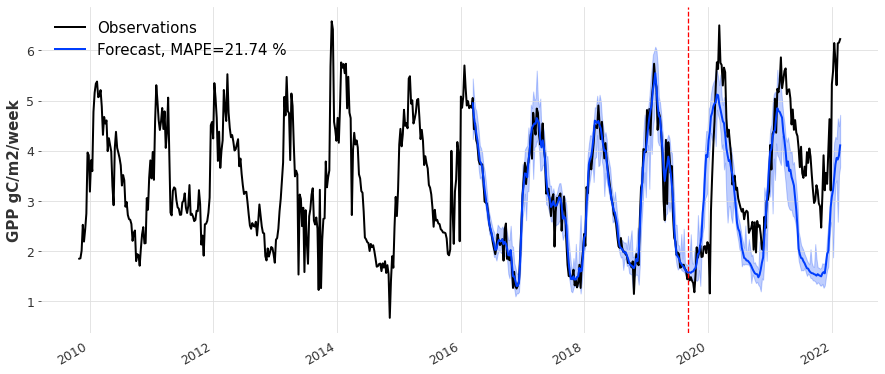

In [14]:
plt.rcParams.update({'font.size': 15})
backtests = scaler.inverse_transform(backtests)

fig,ax = plt.subplots(figsize=(15,6))
series_gpp['GPP_SOLO'].plot(ax=ax, lw=2, label='Observations')

err = mape(backtests[['GPP_SOLO']], series_gpp[['GPP_SOLO']])
backtests['GPP_SOLO'].plot(ax=ax, lw=2, label='{}, MAPE={:.2f} %'.format('Forecast', err), low_quantile=.05, high_quantile=0.95)
plt.ylabel(var_names[0]+' gC/m2/week')
plt.xlabel('')
# plt.title('Backtests with 12-week forecast horizon')
plt.axvline(pd.Timestamp(series_gpp[idx].data_array().time.values[0]), color='red', linestyle='--')
plt.legend()

## Forecast the future

In [15]:
#refit the model on all the data
model.fit(series_gpp_scaled) # past_covariates=covariates

#forecast the future
pred = model.predict(n=n,
                     series=series_gpp_scaled,
                     num_samples=100
                    )

2022-08-22 14:03:45 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 528 samples.
2022-08-22 14:03:45 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-08-22 14:03:45 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-08-22 14:03:45 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-08-22 14:03:45 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-08-22 14:03:45 darts.models.forecasting.torch_forecasting_model WARNING: Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = NBEATSModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some addition

Training: 0it [00:00, ?it/s]

2022-08-22 14:05:37 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=80` reached.


Predicting: 17it [00:00, ?it/s]

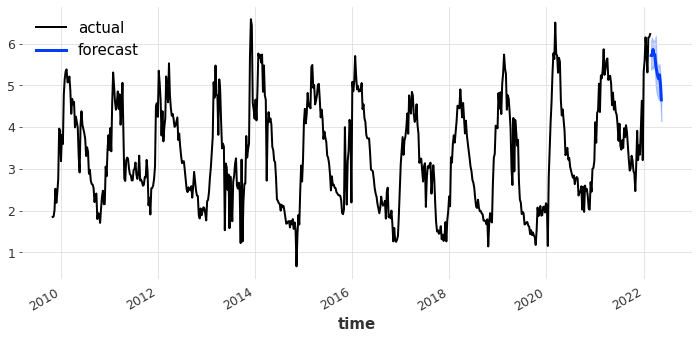

In [16]:
pred_r = scaler.inverse_transform(pred)

fig,ax = plt.subplots(figsize=(12,5))
series_gpp['GPP_SOLO'].plot(ax=ax, label='actual')
pred_r['GPP_SOLO'].plot(ax=ax, label='forecast', lw=3)
plt.legend()

## Cuts

---

### Per pixel time-series

In [17]:
# gpp=xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc').drop('spatial_ref')
# rain=xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/chirps_5km_monthly_1991_2021.nc').drop('spatial_ref').sel(time=slice('2002', '2021'))

# gpp=gpp.isel(latitude=slice(300,305), longitude=slice(300,305))
# rain=rain.isel(latitude=slice(300,305), longitude=slice(300,305))

# # da=da.stack(component=('latitude', 'longitude'))
# # da = da.expand_dims({'sample':1}, axis=-1)
# # da['time'] = da['time'].astype("datetime64[M]")
# # df_in = TimeSeries.from_xarray(da)

# def process(df):
#     df = df.reset_index()
#     df['time'] = df['time'].astype("datetime64[M]")
#     df = df.set_index('time')
#     return df

# tss = []
# i=0
# shape = gpp.shape
# #loop through pixels
# for i in range(shape[1]):
#     for j in range(shape[2]):
#         gpp_df = gpp.isel(latitude=i, longitude=j).drop(['latitude', 'longitude']).to_dataframe()
#         rain_df = rain.isel(latitude=i, longitude=j).drop(['latitude', 'longitude']).to_dataframe()
#         gpp_df = process(gpp_df)
#         rain_df = process(rain_df)
#         df = pd.concat([gpp_df,rain_df], join='inner', axis=1)
#         ts = TimeSeries.from_dataframe(df)
#         covariates = datetime_attribute_timeseries(ts.time_index, attribute="week")
#         covariates = covariates.stack(datetime_attribute_timeseries(ts.time_index, attribute="month"))
#         covariates = covariates.stack(datetime_attribute_timeseries(ts.time_index, attribute="year"))
#         ts = ts.stack(covariates)
#         tss.append(ts)
#         # i+=1
#     i+=1*shape[2]
#     print(" {:04}/{:04}\r".format(i, shape[1]*shape[2]), end="")